# Clustering participants based on their cultural aspects

In [1]:
%%capture

# Boilerplate required to import other notebooks
import ipynb.fs

# From the full "data_preparation" notebook import function(s)
from .full.data_preparation import *

In [2]:
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [3]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

## Defining the set of items which represent the cultural aspects of the survey

### In Spanish

In [4]:
def get_cultural_items_esp():
    # Creating lists that includes the items from the cultural-related constructs

    allCulturalItems = ['¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?',
                        '¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?',
                        '¿Conoces autores/as que trabajen produciendo imágenes?',
                        '¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?',
                        'Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?',
                        'Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?',
                        'Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?',
                        'En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?',
                        'Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?']

    mascVsFem = ['¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?',
                 '¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?',
                 '¿Conoces autores/as que trabajen produciendo imágenes?']

    indivVsCollect = ['¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?',
                      'Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?']

    avoidUndertIndex = ['Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?',
                        'Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?',
                        'En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?',
                        'Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?']

    return allCulturalItems, mascVsFem, indivVsCollect, avoidUndertIndex

### In English

In [5]:
def get_cultural_items_en():
    # Creating lists that includes the items from the cultural-related constructs

    allCulturalItems = ['Do you think that images produced by men are different from those made by women?',
                        'Do you think that in the creation of images work more women, or men?',
                        'Do you know authors who work producing images?',
                        'Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?',
                        'When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?',
                        'By reusing an image, can you redefine the message that the sender has thought about?',
                        'When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?',
                        'On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?',
                        'When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?']

    mascVsFem = ['Do you think that images produced by men are different from those made by women?',
                 'Do you think that in the creation of images work more women, or men?',
                 'Do you know authors who work producing images?']

    indivVsCollect = ['Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?',
                      'When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?']

    avoidUndertIndex = ['By reusing an image, can you redefine the message that the sender has thought about?',
                        'When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?',
                        'On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?',
                        'When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?']

    return allCulturalItems, mascVsFem, indivVsCollect, avoidUndertIndex

## Exploring possible clusters

These functions explore the main clusters available in a dataframe. Functions to manage the data (and column names) available in Spanish and English


Also, we include two examples to show how to use the functions

In [6]:
def test_find_clusters_en(dataframe):
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_en(clusters)
    clusters = drop_optional_columns_en(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_en()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')

    # Ploting our dendrogram.
    colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sources')
    plt.ylabel('Distance')
    dendrogram(cluster_tree, leaf_rotation=80.,
               leaf_font_size=14.,  color_threshold=4.5)
    plt.show()

    fancy_dendrogram(
        cluster_tree,
        truncate_mode='lastp',
        p=12,
        leaf_rotation=80.,
        leaf_font_size=14.,
        show_contracted=True,
        annotate_above=5,  # useful in small plots so annotations don't overlap
        color_threshold=4.5,
    )

    plt.show()

In [7]:
def test_find_clusters_esp(dataframe):
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_esp(clusters)
    clusters = drop_optional_columns_esp(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_esp()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')

    # Ploting our dendrogram.
    colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sources')
    plt.ylabel('Distance')
    dendrogram(cluster_tree, leaf_rotation=80.,
               leaf_font_size=14.,  color_threshold=4.5)
    plt.show()

    fancy_dendrogram(
        cluster_tree,
        truncate_mode='lastp',
        p=12,
        leaf_rotation=80.,
        leaf_font_size=14.,
        show_contracted=True,
        annotate_above=5,  # useful in small plots so annotations don't overlap
        color_threshold=4.5,
    )

    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by the scale function.



,Age,Are you able to express verbally the emotions produced by an image you have seen?,Classify your degree of vision,"Do you have access to devices (computer, mobile, tablet, etc.) connected to the Internet usually?","Do you have any visual deficiencies that affect the visual reception of shapes, colors, distances, etc.?",Do you repeat the images until you get the expected result?,Do you wear glasses or contact lenses?,"Do you, generally, understand the intentions of the author of an image when you see it and share it?","During that use, how many images do you consume (see and share)?",Educational level,...,Which of the paired images do you find most attractive? 1/2 2/2.1,Which of the paired images do you find most attractive? 1/2 2/2.2,Which of the paired images do you find most attractive? 1/2 2/2.3,Which of the paired images do you find most attractive? 1/2 2/2.4,With whom do you usually share images? [1. Friends],With whom do you usually share images? [2. Family],With whom do you usually share images? [3. Partners],With whom do you usually share images? [4. With all my acquaintances],With whom do you usually share images? [5. With nobody],"Within your social networks or mobile applications, do you see visual information that you are not looking for (social awareness campaigns, jokes, advertising, etc.)?"
0,0.348981,-0.484991,-1.218193,0.542426,-0.430664,0.597932,0.965396,-0.450957,-2.079521,0.690860,...,-1.085807,0.781885,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,0.430583
1,2.356095,-0.484991,-1.218193,0.542426,-0.430664,-1.672432,0.965396,-0.450957,0.163788,0.690860,...,0.920974,0.781885,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,1.371487
2,-0.373580,-0.484991,-0.035466,0.542426,-0.430664,0.597932,0.965396,0.603568,1.285442,0.690860,...,-1.085807,-1.278960,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,0.430583
3,-0.132726,-0.484991,-0.035466,0.542426,-0.430664,0.597932,0.965396,0.603568,0.163788,0.690860,...,-1.085807,0.781885,0.714033,-0.938031,0.486926,0.535642,1.244256,-0.547723,-0.179726,-2.392128
4,-0.694718,-1.535804,-0.035466,0.542426,-0.430664,0.597932,0.965396,-0.450957,1.285442,-0.005447,...,-1.085807,0.781885,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,-0.510321


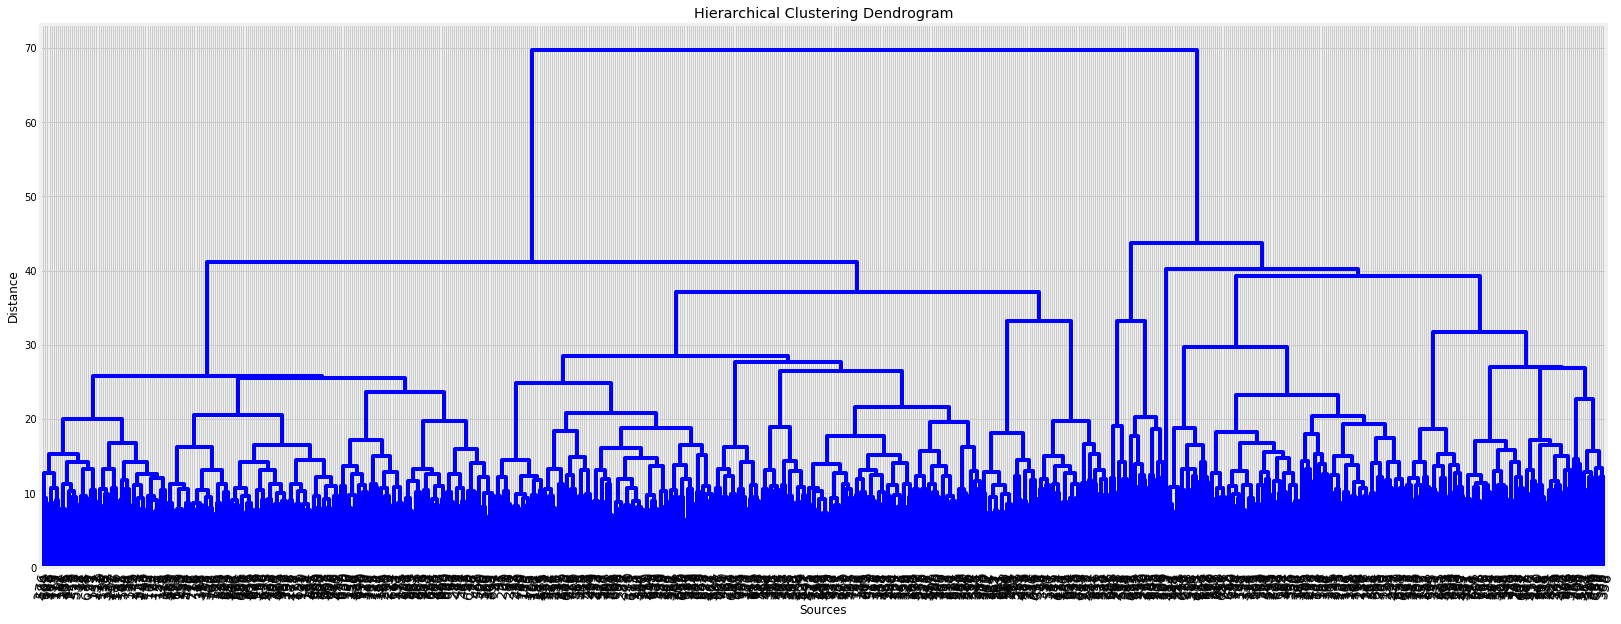

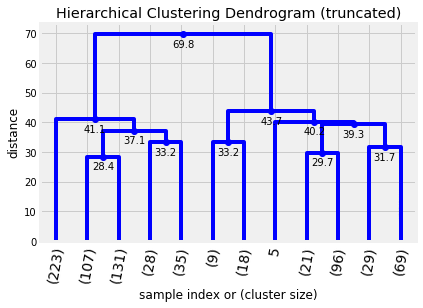

In [8]:
test_find_clusters_en(get_dataframe_analysis_en(True))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by the scale function.



,Clasifica tu grado de visión,"Cuando compartes imágenes, ¿habitualmente las envías a otras personas?","Cuando compartes imágenes, ¿habitualmente las produces tú?","Cuando compartes imágenes, ¿habitualmente las recibes de otras personas?","Cuando generas una imagen, ¿qué tipo de dispositivo usas? (Respuesta múltiple) [1. Cámara de fotos]","Cuando generas una imagen, ¿qué tipo de dispositivo usas? (Respuesta múltiple) [2. Teléfono móvil]","Cuando generas una imagen, ¿qué tipo de dispositivo usas? (Respuesta múltiple) [3. Tableta]","Cuando observas estas imágenes, ¿entiendes lo que pasa, aunque los sujetos/objetos no se muestren de forma completa? 1 2 3 4","Cuando observas una imagen, ¿te preguntas cosas acerca de los personajes/objetos que aparecen en la misma?","Cuando produces imágenes, ¿cuánto tiempo dedicas a prepararlas? (minutos)",...,¿Qué imágenes decides compartir en redes sociales u otros medios tecnológicos? (Respuesta múltiple) [4. Imágenes que con las que pretendo causar una reacción (ej. likes)],"¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [1. Apps de contenidos audiovisuales (Netflix, HBO, etc.)]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [2. Aplicaciones de mensajería (Whatsapp, Facebook Messenger, etc.)]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [3. Bibliotecas de fotos online (Google Photos, iPhoto, etc.)]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [4. Redes sociales (Facebook, Instagram, Twitter, etc.).]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [5. Aplicaciones de vídeo (Youtube, Vimeo, etc.).]",¿Repites las imágenes hasta conseguir el resultado esperado?,"¿Tienes acceso a dispositivos (ordenador, móvil, tablet, etc.) conectados a Internet habitualmente?","¿Tienes alguna carencia visual que afecte a la recepción de formas, colores, distancias, etc.?",¿Utilizas gafas o lentes de contacto?
0,-1.218193,-0.320940,1.017927,-0.329682,-0.781885,0.3119,-0.288675,-0.180359,0.506719,-0.108243,...,-0.656483,0.892330,0.515438,1.006540,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396
1,-1.218193,1.810326,1.017927,1.804210,-0.781885,0.3119,-0.288675,-0.180359,0.506719,-0.108243,...,-0.656483,0.892330,0.515438,-0.993502,-2.062383,0.620062,-1.672432,0.542426,-0.430664,0.965396
2,-0.035466,-0.320940,1.017927,0.737264,-0.781885,0.3119,-0.288675,-0.180359,-0.524192,-0.108243,...,-0.656483,0.892330,0.515438,1.006540,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396
3,-0.035466,0.744693,1.017927,-1.396628,1.278960,0.3119,-0.288675,-0.180359,0.506719,-0.039677,...,1.523268,-1.120662,0.515438,1.006540,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396
4,-0.035466,0.744693,-0.156133,0.737264,1.278960,0.3119,-0.288675,-0.180359,-0.524192,-0.039677,...,1.523268,-1.120662,0.515438,-0.993502,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396


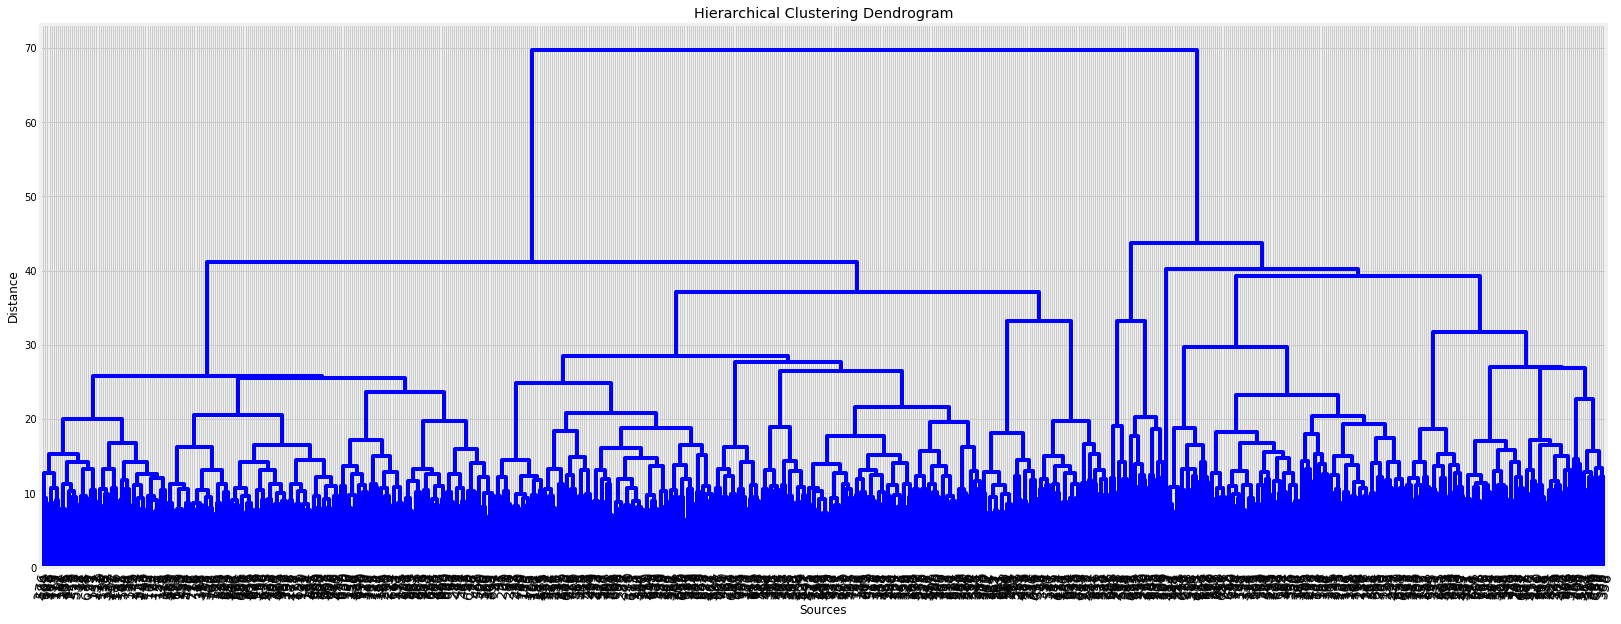

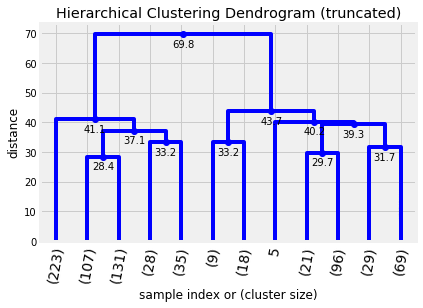

In [9]:
test_find_clusters_esp(get_dataframe_analysis_esp(True))

## Obtaining clusters from data

These functions obtain the clusters from a dataframe and return another dataframe with a new column called `cultural_cluster` which represents the cluster related to cultural aspects assigned to each participant 

Also, we include two examples to show how to use the functions. The Euclidean distance used as a cutoff point to get the clusters in the examples is '28' as shown in the graphs displayed in the test functions `test_find_clusters_en()` and `test_find_clusters_esp()`

In [10]:
def get_dataframe_with_clusters_en(dataframe, max_euc_distance):
    
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_en(clusters)
    clusters = drop_optional_columns_en(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_en()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    # display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')
    
    dataframe_with_clusters = clusters
    clusters_got = fcluster(cluster_tree, max_euc_distance, criterion='distance')
    dataframe_with_clusters['cultural_cluster'] = clusters_got
    
    return dataframe_with_clusters

In [11]:
def get_dataframe_with_clusters_esp(dataframe, max_euc_distance):
    
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_esp(clusters)
    clusters = drop_optional_columns_esp(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_esp()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    # display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')
    
    dataframe_with_clusters = clusters
    clusters_got = fcluster(cluster_tree, max_euc_distance, criterion='distance')
    dataframe_with_clusters['cultural_cluster'] = clusters_got
    
    return dataframe_with_clusters

In [12]:
dataframe_with_clusters_en = get_dataframe_with_clusters_en(get_dataframe_analysis_en(True), 28)

print("Number of clusters: "+ str(len(dataframe_with_clusters_en['cultural_cluster'].unique())))
dataframe_with_clusters_en['cultural_cluster'].value_counts()

Number of clusters: 12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by the scale function.



1     223
3     131
2     107
9      96
11     69
5      35
10     29
4      28
8      21
7      18
6       9
12      1
Name: cultural_cluster, dtype: int64

In [13]:
dataframe_with_clusters_esp = get_dataframe_with_clusters_esp(get_dataframe_analysis_esp(True), 28)

print("Número de clusters: "+ str(len(dataframe_with_clusters_esp['cultural_cluster'].unique())))
dataframe_with_clusters_esp['cultural_cluster'].value_counts()

Número de clusters: 12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by the scale function.



1     223
3     131
2     107
9      96
11     69
5      35
10     29
4      28
8      21
7      18
6       9
12      1
Name: cultural_cluster, dtype: int64

In [14]:
def visualize_cultural_clusters_esp(dataframe):
    # Visualizing the clusters
    # We don't use a discrete colorscale due to Plotly does not support that in this moment https://github.com/plotly/plotly.js/issues/1968

    # Using Cividis color scale for visualization. https://arxiv.org/abs/1712.01662

    cultural_items_dict = [
        {'id': 'Cult1', 'label': '¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?'},
        {'id': 'Cult2', 'label': '¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?'},
        {'id': 'Cult3', 'label': '¿Conoces autores/as que trabajen produciendo imágenes?'},
        {'id': 'Cult4', 'label': '¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?'},
        {'id': 'Cult5', 'label': 'Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?'},
        {'id': 'Cult6', 'label': 'Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?'},
        {'id': 'Cult7',
            'label': 'Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?'},
        {'id': 'Cult8', 'label': 'En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?'},
        {'id': 'Cult9',
            'label': 'Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?'}
    ]

    #
    dimensions_list = []

    for item in cultural_items_dict:
        dimensions_list.append(
            dict(range=[dataframe[item['label']].min(), dataframe[item['label']].max()],
                 #constraintrange = [workCleanDummiesCluster[item['label']].min(), workCleanDummiesCluster[item['label']].max()/3],
                 label=item['id'],
                 values=dataframe[item['label']])
        )

    data = [
        go.Parcoords(
            showlegend=True,
            line=dict(color=dataframe['cultural_cluster'].unique().astype(int),
                      colorscale='Cividis',
                      showscale=True,
                      reversescale=False,
                      cmin=dataframe['cultural_cluster'].min(),
                      cmax=dataframe['cultural_cluster'].max()
                      ),
            dimensions=dimensions_list,
        )
    ]

    '''
    layout = Layout()
    '''

    fig = go.Figure(data=data)
    iplot(fig)

    for item in cultural_items_dict:
        print(item['id']+": "+item['label'])

    all_cultural_items, _, _, _ = get_cultural_items_esp()

    for selected_cluster in dataframe['cultural_cluster'].unique():
        for column in all_cultural_items:
            print("\n\nCluster "+str(selected_cluster) +
                  " || variable: "+str(column))
            display(dataframe.loc[dataframe['cultural_cluster']
                                  == selected_cluster][column].describe())
            print("Media de la variable :"+str(column)+": " +
                  str(dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].mean().round(2)))
            # sns.distplot(workCleanDummiesCluster.loc[workCleanDummiesCluster['cluster'] == selected_cluster][column], kde=False, rug=True);
            data = [go.Bar(x=dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column],
                           y=dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].value_counts())]
            iplot(data)
            plt.show()

In [15]:
def visualize_cultural_clusters_en(dataframe):
    # Visualizing the clusters
    # We don't use a discrete colorscale due to Plotly does not support that in this moment https://github.com/plotly/plotly.js/issues/1968

    # Using Cividis color scale for visualization. https://arxiv.org/abs/1712.01662

    cultural_items_dict = [
        {'id': 'Cult1', 'label': 'Do you think that images produced by men are different from those made by women?'},
        {'id': 'Cult2', 'label': 'Do you think that in the creation of images work more women, or men?'},
        {'id': 'Cult3', 'label': 'Do you know authors who work producing images?'},
        {'id': 'Cult4', 'label': 'Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?'},
        {'id': 'Cult5', 'label': 'When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?'},
        {'id': 'Cult6', 'label': 'By reusing an image, can you redefine the message that the sender has thought about?'},
        {'id': 'Cult7',
            'label': 'When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?'},
        {'id': 'Cult8', 'label': 'On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?'},
        {'id': 'Cult9',
            'label': 'When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?'}
    ]

    # {'id': 'Cult6', 'label': 'Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?'},

    dimensions_list = []

    for item in cultural_items_dict:
        dimensions_list.append(
            dict(range=[dataframe[item['label']].min(), dataframe[item['label']].max()],
                 #constraintrange = [workCleanDummiesCluster[item['label']].min(), workCleanDummiesCluster[item['label']].max()/3],
                 label=item['id'],
                 values=dataframe[item['label']])
        )

    data = [
        go.Parcoords(
            showlegend=True,
            line=dict(color=dataframe['cultural_cluster'].unique().astype(int),
                      colorscale='Cividis',
                      showscale=True,
                      reversescale=False,
                      cmin=dataframe['cultural_cluster'].min(),
                      cmax=dataframe['cultural_cluster'].max()
                      ),
            dimensions=dimensions_list,
        )
    ]

    '''
    layout = Layout()
    '''

    fig = go.Figure(data=data)
    iplot(fig)

    for item in cultural_items_dict:
        print(item['id']+": "+item['label'])

    # Visualizing with bar charts the cultural aspects of each cluster

    all_cultural_items, _, _, _ = get_cultural_items_en()

    for selected_cluster in dataframe['cultural_cluster'].unique():
        for column in all_cultural_items:
            print("\n\nCluster "+str(selected_cluster) +
                  " || feature: "+str(column))
            display(dataframe.loc[dataframe['cultural_cluster']
                                  == selected_cluster][column].describe())
            print("Mean of feature :"+str(column)+": " +
                  str(dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].mean().round(2)))
            # sns.distplot(workCleanDummiesCluster.loc[workCleanDummiesCluster['cluster'] == selected_cluster][column], kde=False, rug=True);
            data = [go.Bar(x=dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column],
                           y=dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].value_counts())]
            iplot(data)
            plt.show()

In [16]:
visualize_cultural_clusters_esp(dataframe_with_clusters_esp)

Cult1: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?
Cult2: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?
Cult3: ¿Conoces autores/as que trabajen produciendo imágenes?
Cult4: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?
Cult5: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?
Cult6: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?
Cult7: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?
Cult8: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entie

count    107.000000
mean       0.355140
std        0.480808
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.36




Cluster 2 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    107.000000
mean       2.747664
std        0.847788
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.75




Cluster 2 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    107.000000
mean       0.186916
std        0.391679
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.19




Cluster 2 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    107.000000
mean       2.289720
std        1.027998
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 2.29




Cluster 2 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    107.00000
mean       2.28972
std        1.14108
min        1.00000
25%        1.00000
50%        2.00000
75%        3.00000
max        5.00000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 2.29




Cluster 2 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    107.000000
mean       1.523364
std        1.084590
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 1.52




Cluster 2 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    107.000000
mean       2.738318
std        0.974548
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 2.74




Cluster 2 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    107.000000
mean       1.990654
std        0.936627
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 1.99




Cluster 2 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    107.000000
mean       2.981308
std        1.189429
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 2.98




Cluster 1 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    223.000000
mean       0.318386
std        0.466898
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.32




Cluster 1 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    223.000000
mean       2.856502
std        0.820371
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.86




Cluster 1 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    223.000000
mean       0.318386
std        0.466898
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.32




Cluster 1 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    223.000000
mean       2.802691
std        1.068211
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 2.8




Cluster 1 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    223.000000
mean       2.295964
std        1.074827
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 2.3




Cluster 1 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    223.000000
mean       1.452915
std        1.033789
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 1.45




Cluster 1 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    223.000000
mean       3.170404
std        1.114048
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 3.17




Cluster 1 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    223.000000
mean       1.748879
std        0.915180
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 1.75




Cluster 1 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    223.000000
mean       3.488789
std        1.021662
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 3.49




Cluster 12 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.0




Cluster 12 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 1.0




Cluster 12 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.0




Cluster 12 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 1.0




Cluster 12 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    1.0
mean     3.0
std      NaN
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 3.0




Cluster 12 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 0.0




Cluster 12 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    1.0
mean     2.0
std      NaN
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 2.0




Cluster 12 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    1.0
mean     2.0
std      NaN
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 2.0




Cluster 12 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    1.0
mean     3.0
std      NaN
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 3.0




Cluster 5 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    35.000000
mean      0.228571
std       0.426043
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.23




Cluster 5 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    35.000000
mean      2.885714
std       0.963188
min       1.000000
25%       3.000000
50%       3.000000
75%       3.500000
max       4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.89




Cluster 5 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    35.000000
mean      0.371429
std       0.490241
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.37




Cluster 5 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    35.000000
mean      3.085714
std       0.981338
min       1.000000
25%       3.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 3.09




Cluster 5 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    35.000000
mean      2.742857
std       1.220965
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 2.74




Cluster 5 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    35.000000
mean      1.028571
std       0.821967
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 1.03




Cluster 5 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    35.000000
mean      2.971429
std       0.821967
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       4.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 2.97




Cluster 5 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    35.000000
mean      2.314286
std       0.963188
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 2.31




Cluster 5 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    35.000000
mean      3.171429
std       0.984758
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 3.17




Cluster 9 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    96.000000
mean      0.250000
std       0.435286
min       0.000000
25%       0.000000
50%       0.000000
75%       0.250000
max       1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.25




Cluster 9 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    96.000000
mean      2.760417
std       0.879531
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.76




Cluster 9 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    96.000000
mean      0.208333
std       0.408248
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.21




Cluster 9 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    96.000000
mean      2.406250
std       1.042044
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 2.41




Cluster 9 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    96.000000
mean      2.135417
std       1.129693
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 2.14




Cluster 9 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    96.000000
mean      1.520833
std       1.187471
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 1.52




Cluster 9 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    96.000000
mean      2.729167
std       1.146887
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 2.73




Cluster 9 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    96.000000
mean      1.739583
std       0.873526
min       1.000000
25%       1.000000
50%       1.500000
75%       2.000000
max       4.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 1.74




Cluster 9 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    96.000000
mean      3.104167
std       1.156029
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 3.1




Cluster 8 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    21.000000
mean      0.380952
std       0.497613
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.38




Cluster 8 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    21.000000
mean      2.428571
std       0.978337
min       1.000000
25%       1.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.43




Cluster 8 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    21.000000
mean      0.380952
std       0.497613
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.38




Cluster 8 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    21.000000
mean      2.666667
std       0.856349
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 2.67




Cluster 8 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    21.000000
mean      2.476190
std       1.209093
min       1.000000
25%       1.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 2.48




Cluster 8 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    21.000000
mean      1.571429
std       1.075706
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 1.57




Cluster 8 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    21.000000
mean      2.904762
std       1.135991
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 2.9




Cluster 8 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    21.000000
mean      2.190476
std       1.249762
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 2.19




Cluster 8 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    21.000000
mean      2.904762
std       1.261141
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 2.9




Cluster 6 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    9.000000
mean     0.666667
std      0.500000
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.67




Cluster 6 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    9.000000
mean     2.333333
std      1.000000
min      1.000000
25%      2.000000
50%      2.000000
75%      3.000000
max      4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.33




Cluster 6 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    9.000000
mean     0.555556
std      0.527046
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.56




Cluster 6 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    9.000000
mean     3.000000
std      0.707107
min      2.000000
25%      3.000000
50%      3.000000
75%      3.000000
max      4.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 3.0




Cluster 6 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    9.000000
mean     3.111111
std      0.927961
min      2.000000
25%      3.000000
50%      3.000000
75%      3.000000
max      5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 3.11




Cluster 6 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    9.000000
mean     1.111111
std      0.781736
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 1.11




Cluster 6 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    9.000000
mean     2.888889
std      0.927961
min      1.000000
25%      3.000000
50%      3.000000
75%      3.000000
max      4.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 2.89




Cluster 6 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    9.000000
mean     2.666667
std      0.866025
min      1.000000
25%      2.000000
50%      3.000000
75%      3.000000
max      4.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 2.67




Cluster 6 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    9.000000
mean     3.111111
std      1.054093
min      1.000000
25%      3.000000
50%      3.000000
75%      4.000000
max      4.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 3.11




Cluster 3 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    131.000000
mean       0.290076
std        0.455539
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.29




Cluster 3 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    131.000000
mean       2.648855
std        0.876388
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.65




Cluster 3 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    131.000000
mean       0.206107
std        0.406061
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.21




Cluster 3 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    131.000000
mean       2.625954
std        1.025340
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 2.63




Cluster 3 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    131.000000
mean       2.687023
std        1.144108
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 2.69




Cluster 3 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    131.000000
mean       1.175573
std        1.041308
min        0.000000
25%        0.500000
50%        1.000000
75%        1.000000
max        3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 1.18




Cluster 3 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    131.000000
mean       3.007634
std        0.881399
min        1.000000
25%        3.000000
50%        3.000000
75%        3.500000
max        5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 3.01




Cluster 3 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    131.000000
mean       2.129771
std        1.105211
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 2.13




Cluster 3 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    131.000000
mean       3.045802
std        0.935312
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 3.05




Cluster 11 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    69.000000
mean      0.434783
std       0.499360
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.43




Cluster 11 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    69.000000
mean      2.260870
std       0.917993
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.26




Cluster 11 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    69.000000
mean      0.492754
std       0.503610
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.49




Cluster 11 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    69.000000
mean      2.797101
std       0.900649
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 2.8




Cluster 11 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    69.000000
mean      2.637681
std       0.969703
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 2.64




Cluster 11 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    69.000000
mean      1.028986
std       0.969703
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 1.03




Cluster 11 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    69.000000
mean      2.840580
std       0.994443
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 2.84




Cluster 11 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    69.000000
mean      2.681159
std       1.143945
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 2.68




Cluster 11 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    69.000000
mean      2.855072
std       1.018583
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 2.86




Cluster 10 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    29.000000
mean      0.379310
std       0.493804
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.38




Cluster 10 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    29.000000
mean      2.137931
std       0.833415
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.14




Cluster 10 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    29.000000
mean      0.206897
std       0.412251
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.21




Cluster 10 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    29.000000
mean      2.448276
std       0.948164
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 2.45




Cluster 10 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    29.000000
mean      2.758621
std       0.786274
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 2.76




Cluster 10 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    29.000000
mean      1.206897
std       1.114172
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 1.21




Cluster 10 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    29.000000
mean      2.724138
std       1.161789
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 2.72




Cluster 10 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    29.000000
mean      2.379310
std       0.775232
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 2.38




Cluster 10 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    29.000000
mean      2.517241
std       0.986360
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 2.52




Cluster 7 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    18.000000
mean      0.388889
std       0.501631
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.39




Cluster 7 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    18.000000
mean      2.722222
std       0.894792
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.72




Cluster 7 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    18.000000
mean      0.055556
std       0.235702
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.06




Cluster 7 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    18.000000
mean      2.277778
std       1.127494
min       1.000000
25%       1.250000
50%       2.000000
75%       3.000000
max       4.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 2.28




Cluster 7 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    18.000000
mean      1.833333
std       1.043185
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       4.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 1.83




Cluster 7 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    18.000000
mean      1.555556
std       1.247219
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 1.56




Cluster 7 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    18.000000
mean      2.555556
std       1.423427
min       1.000000
25%       1.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 2.56




Cluster 7 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    18.000000
mean      1.611111
std       0.849837
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 1.61




Cluster 7 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    18.000000
mean      2.444444
std       1.293523
min       1.000000
25%       1.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 2.44




Cluster 4 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    28.000000
mean      0.535714
std       0.507875
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Media de la variable :¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?: 0.54




Cluster 4 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    28.00000
mean      2.50000
std       0.83887
min       1.00000
25%       2.00000
50%       3.00000
75%       3.00000
max       3.00000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Media de la variable :¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?: 2.5




Cluster 4 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?


count    28.000000
mean      0.642857
std       0.487950
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Media de la variable :¿Conoces autores/as que trabajen produciendo imágenes?: 0.64




Cluster 4 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    28.000000
mean      3.535714
std       0.744468
min       2.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Media de la variable :¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?: 3.54




Cluster 4 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    28.000000
mean      3.964286
std       0.744468
min       2.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Media de la variable :Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?: 3.96




Cluster 4 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    28.000000
mean      0.964286
std       0.188982
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Media de la variable :Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?: 0.96




Cluster 4 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    28.000000
mean      3.892857
std       0.685257
min       2.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Media de la variable :Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?: 3.89




Cluster 4 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    28.000000
mean      3.857143
std       0.803432
min       2.000000
25%       3.750000
50%       4.000000
75%       4.000000
max       5.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Media de la variable :En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?: 3.86




Cluster 4 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    28.000000
mean      3.928571
std       0.813250
min       2.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Media de la variable :Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?: 3.93


In [17]:
visualize_cultural_clusters_en(dataframe_with_clusters_en)

Cult1: Do you think that images produced by men are different from those made by women?
Cult2: Do you think that in the creation of images work more women, or men?
Cult3: Do you know authors who work producing images?
Cult4: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?
Cult5: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?
Cult6: By reusing an image, can you redefine the message that the sender has thought about?
Cult7: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?
Cult8: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to d

count    107.000000
mean       0.355140
std        0.480808
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.36




Cluster 2 || feature: Do you think that in the creation of images work more women, or men?


count    107.000000
mean       2.747664
std        0.847788
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.75




Cluster 2 || feature: Do you know authors who work producing images?


count    107.000000
mean       0.186916
std        0.391679
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.19




Cluster 2 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    107.000000
mean       2.289720
std        1.027998
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 2.29




Cluster 2 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    107.00000
mean       2.28972
std        1.14108
min        1.00000
25%        1.00000
50%        2.00000
75%        3.00000
max        5.00000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 2.29




Cluster 2 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    107.000000
mean       1.523364
std        1.084590
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 1.52




Cluster 2 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    107.000000
mean       2.738318
std        0.974548
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 2.74




Cluster 2 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    107.000000
mean       1.990654
std        0.936627
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 1.99




Cluster 2 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    107.000000
mean       2.981308
std        1.189429
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 2.98




Cluster 1 || feature: Do you think that images produced by men are different from those made by women?


count    223.000000
mean       0.318386
std        0.466898
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.32




Cluster 1 || feature: Do you think that in the creation of images work more women, or men?


count    223.000000
mean       2.856502
std        0.820371
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.86




Cluster 1 || feature: Do you know authors who work producing images?


count    223.000000
mean       0.318386
std        0.466898
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.32




Cluster 1 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    223.000000
mean       2.802691
std        1.068211
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 2.8




Cluster 1 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    223.000000
mean       2.295964
std        1.074827
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 2.3




Cluster 1 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    223.000000
mean       1.452915
std        1.033789
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 1.45




Cluster 1 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    223.000000
mean       3.170404
std        1.114048
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 3.17




Cluster 1 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    223.000000
mean       1.748879
std        0.915180
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 1.75




Cluster 1 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    223.000000
mean       3.488789
std        1.021662
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 3.49




Cluster 12 || feature: Do you think that images produced by men are different from those made by women?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.0




Cluster 12 || feature: Do you think that in the creation of images work more women, or men?


count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 1.0




Cluster 12 || feature: Do you know authors who work producing images?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.0




Cluster 12 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 1.0




Cluster 12 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    1.0
mean     3.0
std      NaN
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 3.0




Cluster 12 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 0.0




Cluster 12 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    1.0
mean     2.0
std      NaN
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 2.0




Cluster 12 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    1.0
mean     2.0
std      NaN
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 2.0




Cluster 12 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    1.0
mean     3.0
std      NaN
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 3.0




Cluster 5 || feature: Do you think that images produced by men are different from those made by women?


count    35.000000
mean      0.228571
std       0.426043
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.23




Cluster 5 || feature: Do you think that in the creation of images work more women, or men?


count    35.000000
mean      2.885714
std       0.963188
min       1.000000
25%       3.000000
50%       3.000000
75%       3.500000
max       4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.89




Cluster 5 || feature: Do you know authors who work producing images?


count    35.000000
mean      0.371429
std       0.490241
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.37




Cluster 5 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    35.000000
mean      3.085714
std       0.981338
min       1.000000
25%       3.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 3.09




Cluster 5 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    35.000000
mean      2.742857
std       1.220965
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 2.74




Cluster 5 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    35.000000
mean      1.028571
std       0.821967
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 1.03




Cluster 5 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    35.000000
mean      2.971429
std       0.821967
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       4.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 2.97




Cluster 5 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    35.000000
mean      2.314286
std       0.963188
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 2.31




Cluster 5 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    35.000000
mean      3.171429
std       0.984758
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 3.17




Cluster 9 || feature: Do you think that images produced by men are different from those made by women?


count    96.000000
mean      0.250000
std       0.435286
min       0.000000
25%       0.000000
50%       0.000000
75%       0.250000
max       1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.25




Cluster 9 || feature: Do you think that in the creation of images work more women, or men?


count    96.000000
mean      2.760417
std       0.879531
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.76




Cluster 9 || feature: Do you know authors who work producing images?


count    96.000000
mean      0.208333
std       0.408248
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.21




Cluster 9 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    96.000000
mean      2.406250
std       1.042044
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 2.41




Cluster 9 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    96.000000
mean      2.135417
std       1.129693
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 2.14




Cluster 9 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    96.000000
mean      1.520833
std       1.187471
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 1.52




Cluster 9 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    96.000000
mean      2.729167
std       1.146887
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 2.73




Cluster 9 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    96.000000
mean      1.739583
std       0.873526
min       1.000000
25%       1.000000
50%       1.500000
75%       2.000000
max       4.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 1.74




Cluster 9 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    96.000000
mean      3.104167
std       1.156029
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 3.1




Cluster 8 || feature: Do you think that images produced by men are different from those made by women?


count    21.000000
mean      0.380952
std       0.497613
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.38




Cluster 8 || feature: Do you think that in the creation of images work more women, or men?


count    21.000000
mean      2.428571
std       0.978337
min       1.000000
25%       1.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.43




Cluster 8 || feature: Do you know authors who work producing images?


count    21.000000
mean      0.380952
std       0.497613
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.38




Cluster 8 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    21.000000
mean      2.666667
std       0.856349
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 2.67




Cluster 8 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    21.000000
mean      2.476190
std       1.209093
min       1.000000
25%       1.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 2.48




Cluster 8 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    21.000000
mean      1.571429
std       1.075706
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 1.57




Cluster 8 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    21.000000
mean      2.904762
std       1.135991
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 2.9




Cluster 8 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    21.000000
mean      2.190476
std       1.249762
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 2.19




Cluster 8 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    21.000000
mean      2.904762
std       1.261141
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 2.9




Cluster 6 || feature: Do you think that images produced by men are different from those made by women?


count    9.000000
mean     0.666667
std      0.500000
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.67




Cluster 6 || feature: Do you think that in the creation of images work more women, or men?


count    9.000000
mean     2.333333
std      1.000000
min      1.000000
25%      2.000000
50%      2.000000
75%      3.000000
max      4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.33




Cluster 6 || feature: Do you know authors who work producing images?


count    9.000000
mean     0.555556
std      0.527046
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.56




Cluster 6 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    9.000000
mean     3.000000
std      0.707107
min      2.000000
25%      3.000000
50%      3.000000
75%      3.000000
max      4.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 3.0




Cluster 6 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    9.000000
mean     3.111111
std      0.927961
min      2.000000
25%      3.000000
50%      3.000000
75%      3.000000
max      5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 3.11




Cluster 6 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    9.000000
mean     1.111111
std      0.781736
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 1.11




Cluster 6 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    9.000000
mean     2.888889
std      0.927961
min      1.000000
25%      3.000000
50%      3.000000
75%      3.000000
max      4.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 2.89




Cluster 6 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    9.000000
mean     2.666667
std      0.866025
min      1.000000
25%      2.000000
50%      3.000000
75%      3.000000
max      4.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 2.67




Cluster 6 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    9.000000
mean     3.111111
std      1.054093
min      1.000000
25%      3.000000
50%      3.000000
75%      4.000000
max      4.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 3.11




Cluster 3 || feature: Do you think that images produced by men are different from those made by women?


count    131.000000
mean       0.290076
std        0.455539
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.29




Cluster 3 || feature: Do you think that in the creation of images work more women, or men?


count    131.000000
mean       2.648855
std        0.876388
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.65




Cluster 3 || feature: Do you know authors who work producing images?


count    131.000000
mean       0.206107
std        0.406061
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.21




Cluster 3 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    131.000000
mean       2.625954
std        1.025340
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 2.63




Cluster 3 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    131.000000
mean       2.687023
std        1.144108
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 2.69




Cluster 3 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    131.000000
mean       1.175573
std        1.041308
min        0.000000
25%        0.500000
50%        1.000000
75%        1.000000
max        3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 1.18




Cluster 3 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    131.000000
mean       3.007634
std        0.881399
min        1.000000
25%        3.000000
50%        3.000000
75%        3.500000
max        5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 3.01




Cluster 3 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    131.000000
mean       2.129771
std        1.105211
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 2.13




Cluster 3 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    131.000000
mean       3.045802
std        0.935312
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 3.05




Cluster 11 || feature: Do you think that images produced by men are different from those made by women?


count    69.000000
mean      0.434783
std       0.499360
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.43




Cluster 11 || feature: Do you think that in the creation of images work more women, or men?


count    69.000000
mean      2.260870
std       0.917993
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.26




Cluster 11 || feature: Do you know authors who work producing images?


count    69.000000
mean      0.492754
std       0.503610
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.49




Cluster 11 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    69.000000
mean      2.797101
std       0.900649
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 2.8




Cluster 11 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    69.000000
mean      2.637681
std       0.969703
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 2.64




Cluster 11 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    69.000000
mean      1.028986
std       0.969703
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 1.03




Cluster 11 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    69.000000
mean      2.840580
std       0.994443
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 2.84




Cluster 11 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    69.000000
mean      2.681159
std       1.143945
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 2.68




Cluster 11 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    69.000000
mean      2.855072
std       1.018583
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 2.86




Cluster 10 || feature: Do you think that images produced by men are different from those made by women?


count    29.000000
mean      0.379310
std       0.493804
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.38




Cluster 10 || feature: Do you think that in the creation of images work more women, or men?


count    29.000000
mean      2.137931
std       0.833415
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.14




Cluster 10 || feature: Do you know authors who work producing images?


count    29.000000
mean      0.206897
std       0.412251
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.21




Cluster 10 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    29.000000
mean      2.448276
std       0.948164
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 2.45




Cluster 10 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    29.000000
mean      2.758621
std       0.786274
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 2.76




Cluster 10 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    29.000000
mean      1.206897
std       1.114172
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 1.21




Cluster 10 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    29.000000
mean      2.724138
std       1.161789
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 2.72




Cluster 10 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    29.000000
mean      2.379310
std       0.775232
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 2.38




Cluster 10 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    29.000000
mean      2.517241
std       0.986360
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 2.52




Cluster 7 || feature: Do you think that images produced by men are different from those made by women?


count    18.000000
mean      0.388889
std       0.501631
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.39




Cluster 7 || feature: Do you think that in the creation of images work more women, or men?


count    18.000000
mean      2.722222
std       0.894792
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.72




Cluster 7 || feature: Do you know authors who work producing images?


count    18.000000
mean      0.055556
std       0.235702
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.06




Cluster 7 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    18.000000
mean      2.277778
std       1.127494
min       1.000000
25%       1.250000
50%       2.000000
75%       3.000000
max       4.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 2.28




Cluster 7 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    18.000000
mean      1.833333
std       1.043185
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       4.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 1.83




Cluster 7 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    18.000000
mean      1.555556
std       1.247219
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 1.56




Cluster 7 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    18.000000
mean      2.555556
std       1.423427
min       1.000000
25%       1.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 2.56




Cluster 7 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    18.000000
mean      1.611111
std       0.849837
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 1.61




Cluster 7 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    18.000000
mean      2.444444
std       1.293523
min       1.000000
25%       1.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 2.44




Cluster 4 || feature: Do you think that images produced by men are different from those made by women?


count    28.000000
mean      0.535714
std       0.507875
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Mean of feature :Do you think that images produced by men are different from those made by women?: 0.54




Cluster 4 || feature: Do you think that in the creation of images work more women, or men?


count    28.00000
mean      2.50000
std       0.83887
min       1.00000
25%       2.00000
50%       3.00000
75%       3.00000
max       3.00000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Mean of feature :Do you think that in the creation of images work more women, or men?: 2.5




Cluster 4 || feature: Do you know authors who work producing images?


count    28.000000
mean      0.642857
std       0.487950
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: Do you know authors who work producing images?, dtype: float64

Mean of feature :Do you know authors who work producing images?: 0.64




Cluster 4 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    28.000000
mean      3.535714
std       0.744468
min       2.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Mean of feature :Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?: 3.54




Cluster 4 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    28.000000
mean      3.964286
std       0.744468
min       2.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Mean of feature :When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?: 3.96




Cluster 4 || feature: By reusing an image, can you redefine the message that the sender has thought about?


count    28.000000
mean      0.964286
std       0.188982
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Mean of feature :By reusing an image, can you redefine the message that the sender has thought about?: 0.96




Cluster 4 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    28.000000
mean      3.892857
std       0.685257
min       2.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Mean of feature :When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?: 3.89




Cluster 4 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    28.000000
mean      3.857143
std       0.803432
min       2.000000
25%       3.750000
50%       4.000000
75%       4.000000
max       5.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Mean of feature :On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?: 3.86




Cluster 4 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    28.000000
mean      3.928571
std       0.813250
min       2.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Mean of feature :When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?: 3.93
